<a href="https://www.kaggle.com/code/melihkotman/spotify-audio-analysis-knn-naive-bayes?scriptVersionId=297746547" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Spotify Audio Features Analysis: Phase ML Lab

Bu notebook'ta, 2023'ün en çok dinlenen Spotify şarkılarını analiz ediyoruz. Amacımız sadece şarkıların isimlerine veya sanatçılarına bakarak değil, şarkının "mühendisliğine" (bpm, enerji, akustiklik, dans edilebilirlik) bakarak **"Bu şarkı bir MEGA HIT mi?"** sorusunu tahmin etmektir.

### What Will We Do?
1. **Target Creation (Feature Engineering):** Sürekli bir değişken olan 'streams' (dinlenme) sütununu, Sınıflandırma (Classification) yapabilmek için 0 ve 1'lere dönüştüreceğiz.
2. **Korelasyon ve EDA:** Hangi ses özelliği Mega Hit olmayı tetikliyor?
3. **Faz 1 Modelleri:** K-Nearest Neighbors (KNN) ve Naive Bayes (GaussianNB) algoritmalarını yarıştıracağız.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Data Loading
# encoding='latin-1' 
df = pd.read_csv('/kaggle/input/datasets/abdulszz/spotify-most-streamed-songs/Spotify Most Streamed Songs.csv', encoding='latin-1')

# Columns Cleaning
df.columns = df.columns.str.replace('_%', '').str.replace('-', '_').str.lower()

print("--- Veri Seti Boyutu ---")
print(df.shape)
display(df.head(3))

--- Veri Seti Boyutu ---
(953, 25)


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,key,mode,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness,cover_url
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,B,Major,80,89,83,31,0,8,4,Not Found
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,C#,Major,71,61,74,7,0,10,4,https://i.scdn.co/image/ab67616d0000b2730656d5...
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,F,Major,51,32,53,17,0,31,6,https://i.scdn.co/image/ab67616d0000b273e85259...


## Target Creation and Feature Engineering (Target Engineering)
- Veri Temizleme ve Mega Hit Yaratma (Data Cleaning and Mega Hit Creation)

In [3]:
# 'streams' column can have some junk datas, we will turn them numeric.
df['streams'] = pd.to_numeric(df['streams'], errors='coerce')

# Deleting Null Datas
df = df.dropna()

# Creating y(target) variable
# Dinlenme Sayılarının Medyanını Bul
# Medyan Üstü: Mega Hit -> 1, Medyan Altı: Hit -> 0
median_streams = df['streams'].median()

df['is_mega_hit'] = (df['streams'] >= median_streams).astype(int)

print(f"Median Listening (Threshold): {median_streams:,.0f}")
print("Class Distribution")
print(df['is_mega_hit'].value_counts())

# Audio Features Selection
audio_features = ['bpm', 'danceability', 'valence', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'is_mega_hit']
df_ml = df[audio_features]

Median Listening (Threshold): 263,836,780
Class Distribution
is_mega_hit
0    408
1    408
Name: count, dtype: int64


## Exploratory Data Analysis (EDA)

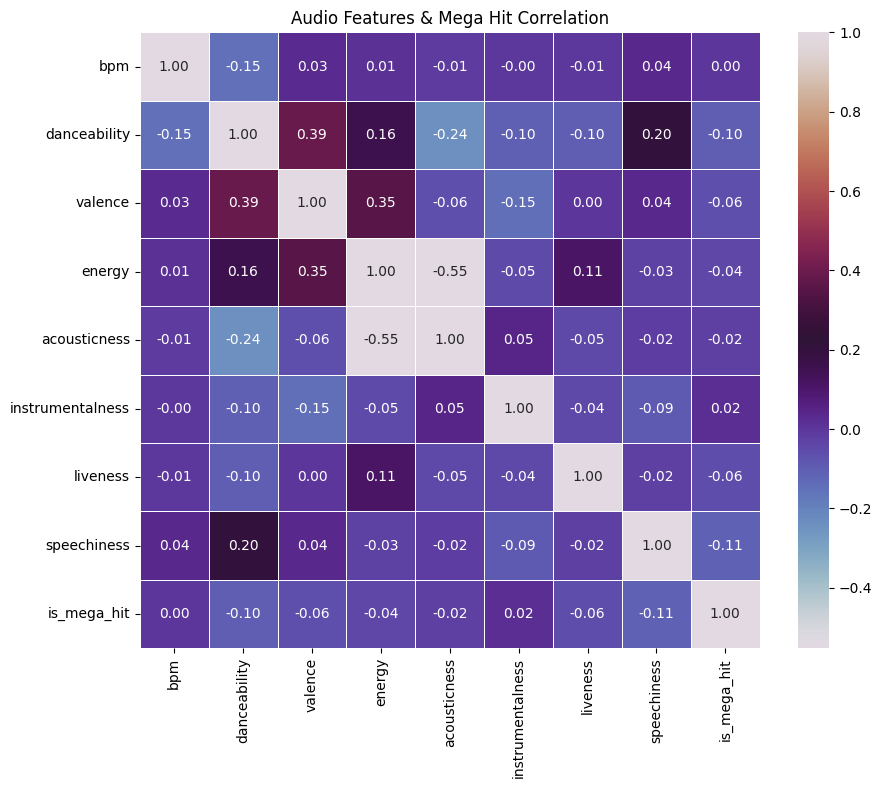

In [5]:
# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_ml.corr(),
    annot=True,
    cmap= 'twilight',
    fmt='.2f',
    linewidths=0.5
)
plt.title("Audio Features & Mega Hit Correlation")
plt.show()

## Models KNN and Naive Bayes

In [7]:
# Modelling (KNN and NB)
# 1. X and y Splitting
X = df_ml.drop('is_mega_hit',axis=1)
y = df_ml['is_mega_hit']

# 2. Train/Test Split (%20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Scaling (StandardScaler)
# KNN mesafe temellidir
# Naive Bayes olasılık temellidir gerek yok fakat zarar görmez.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Models
models = {
    "KNN": KNeighborsClassifier(n_neighbors = 5),
    "NB": GaussianNB()
}

# 5. Model Testing and Training
for name,model in models.items():
    # Model Training
    model.fit(X_train_scaled, y_train)

    # Model Prediction
    y_pred = model.predict(X_test_scaled)

    # Classification Report
    print(f"--- {name} Scores ---")
    print(classification_report(y_test, y_pred))

--- KNN Scores ---
              precision    recall  f1-score   support

           0       0.56      0.51      0.54        78
           1       0.59      0.64      0.61        86

    accuracy                           0.58       164
   macro avg       0.58      0.58      0.58       164
weighted avg       0.58      0.58      0.58       164

--- NB Scores ---
              precision    recall  f1-score   support

           0       0.54      0.65      0.59        78
           1       0.61      0.50      0.55        86

    accuracy                           0.57       164
   macro avg       0.58      0.58      0.57       164
weighted avg       0.58      0.57      0.57       164



## Audio Features Insights

Faz 1 modellerini (KNN ve Naive Bayes) kullanarak şarkıların sadece "Ses Özelliklerine (Audio Features)" bakarak Mega Hit olup olamayacaklarını tahmin etmeye çalıştık.

### Model Reviews:
* **Genel Performans:** İki model de **%57 - %58 Accuracy** civarında kalmıştır. Bu oran yazı-tura atmaktan (%50) sadece biraz daha iyidir.
* **Zıt Karakterli Modeller:** * **KNN**, birbirine benzeyen şarkıları gruplayarak "Mega Hit (1)" sınıfını tahmin etmede daha başarılı olmuştur (Recall: 0.64).
  * **Naive Bayes** ise olasılıkları hesaplarken daha tutucu davranmış ve "Hit (0)" sınıfını bulmada öne çıkmıştır (Recall: 0.65).

### Comments for Analyse
Bu düşük skorlar bize veri biliminde çok önemli bir ders vermektedir: **Her şeyi verideki mevcut sütunlarla açıklayamayız.** Bir şarkının 1 Milyar barajını aşıp Mega Hit olması; sadece enerjisine, temposuna (BPM) veya ne kadar dans edilebilir olduğuna bağlı değildir. Sanatçının popülaritesi, pazarlama bütçesi, TikTok trendleri ve küresel olaylar (örneğin yaz ayları) bu durumu belirleyen asıl "Gizli Özelliklerdir (Hidden Features)".

## Marketing Feature Engineering and EDA
- Verilerin sadece müziğin özellikleriyle değil dinlenme listeleri eklenmesi gibi birçok pazarlama verisine bağlı olduğuna vardığımız için pazarlamayla ilgili özellikler ile ilgileneceğiz

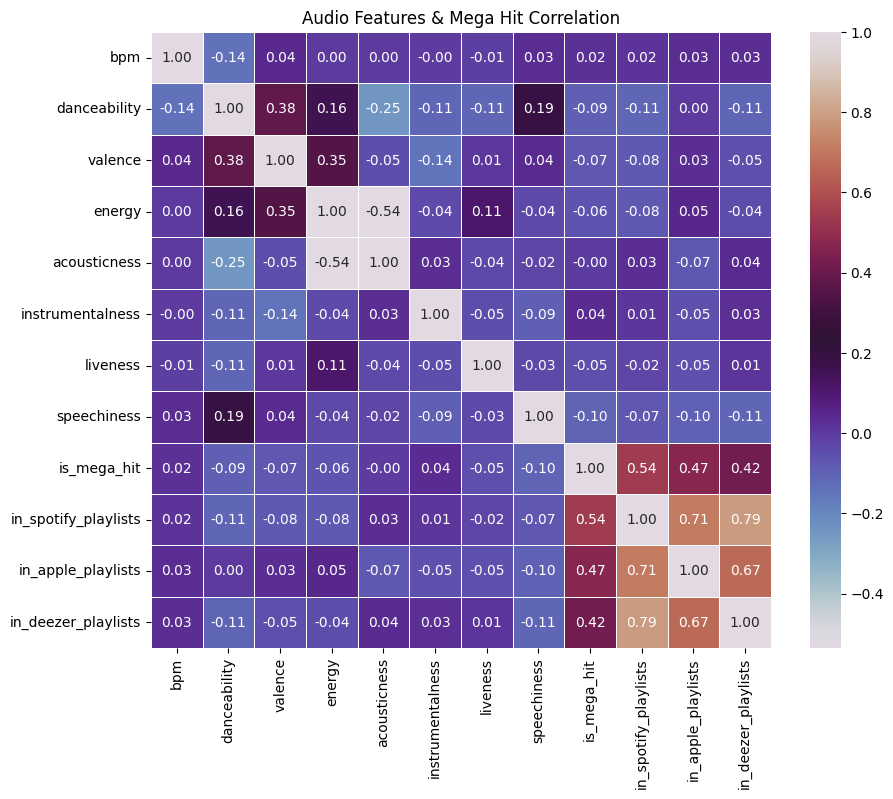

In [9]:
# Playlists Power
# Playlist Columns will be numeric.
playlist_cols = ['in_spotify_playlists','in_apple_playlists','in_deezer_playlists']
for col in playlist_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Creating New DataFrame
playlist_audio_features = ['bpm', 'danceability', 'valence', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'is_mega_hit'] + playlist_cols

# Null Values Dropping
df_ml_v2 = df[playlist_audio_features].dropna()

# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_ml_v2.corr(),
    annot=True,
    cmap= 'twilight',
    fmt='.2f',
    linewidths=0.5
)
plt.title("Audio and Playlists Features & Mega Hit Correlation")
plt.show()

In [11]:
# New X and y
X_v2 = df_ml_v2.drop('is_mega_hit',axis=1)
y_v2 = df_ml_v2['is_mega_hit']

# New Train/Test Splitting
X_train_v2,X_test_v2,y_train_v2,y_test_v2 = train_test_split(X_v2, y_v2, test_size=0.2,random_state=42)

# Scaling (Standard Scaler)
scaler2 = StandardScaler()
X_train2_scaled = scaler2.fit_transform(X_train_v2)
X_test2_scaled = scaler2.transform(X_test_v2)

# 4. Models
models = {
    "KNN": KNeighborsClassifier(n_neighbors = 5),
    "NB": GaussianNB()
}

# 5. Model Testing and Training
for name,model in models.items():
    # Model Training
    model.fit(X_train2_scaled, y_train_v2)

    # Model Prediction
    y_pred_v2 = model.predict(X_test2_scaled)

    # Classification Report
    print(f"--- {name} Scores ---")
    print(classification_report(y_test_v2, y_pred_v2))

--- KNN Scores ---
              precision    recall  f1-score   support

           0       0.71      0.82      0.77        85
           1       0.72      0.58      0.64        66

    accuracy                           0.72       151
   macro avg       0.72      0.70      0.70       151
weighted avg       0.72      0.72      0.71       151

--- NB Scores ---
              precision    recall  f1-score   support

           0       0.75      0.89      0.81        85
           1       0.82      0.61      0.70        66

    accuracy                           0.77       151
   macro avg       0.78      0.75      0.75       151
weighted avg       0.78      0.77      0.76       151



## Marketing and Audio Insight

Modelimizi sadece "Ses Özellikleri (Audio Features)" ile eğittiğimizde %58 gibi düşük bir doğruluk (Accuracy) almıştık. Ancak modelimize **Pazarlama ve Dağıtım Gücünü** temsil eden `Playlist` (Oynatma Listesi) verilerini eklediğimizde sonuçlar dramatik bir şekilde iyileşti.

### Model Performansındaki Sıçrama:
* **Eski Accuracy (Sadece Müzik):** ~%58
* **Yeni Accuracy (Müzik + Pazarlama):** **KNN için %72, Naive Bayes için %77!**
* **Hassasiyet Artışı:** Naive Bayes modeli, "Mega Hit" dediği şarkılarda **%82 Precision (Hassasiyet)** oranına ulaşarak çok güvenilir bir müzik yapımcısına dönüştü.

### Veri Bilimi Çıkarımı (Neden İyileşti?):
Bir makine öğrenmesi modelinin başarılı olabilmesi için hedef değişkenle (Mega Hit) **yüksek korelasyona (pozitif veya negatif)** sahip özelliklere ihtiyacı vardır. Sadece dans edilebilirlik veya enerji, hedef değişkenle güçlü bir matematiksel bağ kuramadı. Ancak çalma listelerine girme verileri (özellikle Spotify ve Apple) modelin net sınır çizgileri (decision boundaries) çizmesini sağladı ve hem `Recall` hem de `Accuracy` değerlerini şaha kaldırdı.

### Müzik Endüstrisi İçin Acı Gerçek:
Mükemmel bir şarkı yapmak (yüksek enerji, harika bpm, dans edilebilirlik) hit olmak için tek başına yetmez. **Dağıtım ağınız ve pazarlama stratejiniz (Playlist'lere girmek) en az müziğin kendisi kadar, hatta ondan daha önemlidir.** Bir şarkı doğru oynatma listelerine giremezse, algoritmaların derinliklerinde kaybolmaya mahkumdur.